# Homework Python Basics

Group: Team_particle_2
Members: 
* Vicente Arevalo
* Brandon Minta
* Franklin Limaico
* Daniel Pozo
* Sebastian Valladares

In [28]:
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt

In [29]:
file_name = "turbulence_sub_hr.vtk"

In [30]:
mesh = pv.read(file_name)

In [31]:
print(mesh)

RectilinearGrid (0x7f1899e81fa0)
  N Cells:	40000
  N Points:	40401
  X Bounds:	-2.000e+00, 2.000e+00
  Y Bounds:	-2.000e+00, 2.000e+00
  Z Bounds:	0.000e+00, 0.000e+00
  Dimensions:	201, 201, 1
  N Arrays:	5



In [32]:
# Now, we read all the scalar and vector quantities

rho = pv.get_array(mesh, "rho", preference = 'cell') # density in code units
vx1 = pv.get_array(mesh, "vx1", preference = 'cell') # x velocity component in code units
vx2 = pv.get_array(mesh, "vx2", preference = 'cell') # y velocity component in code units
Bx1 = pv.get_array(mesh, "Bx1", preference = 'cell') # x magnetic field component in code units
Bx2 = pv.get_array(mesh, "Bx2", preference = 'cell') # y magnetic field component in code units

In [33]:
# The above arrays are 1D, so we need to make them 2D
# To check you can run: print(rho.shape)

rho_2D = rho.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)
vx1_2D = vx1.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)
vx2_2D = vx2.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)
Bx1_2D = Bx1.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)
Bx2_2D = Bx2.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)

In [34]:
# Create a 2D grid using metadata information

x = np.linspace(mesh.bounds[0], mesh.bounds[1], mesh.dimensions[0] - 1)
y = np.linspace(mesh.bounds[2], mesh.bounds[3], mesh.dimensions[1] - 1)

X, Y = np.meshgrid(x, y)

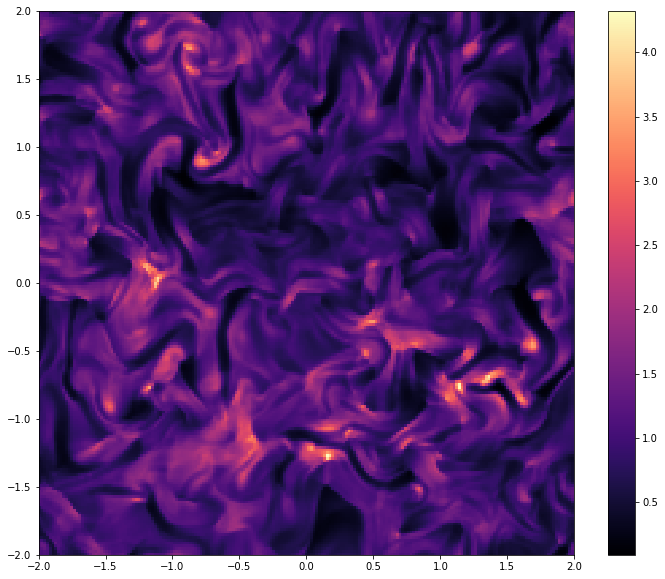

In [35]:
# And we are ready to interpolate our data onto the mesh:

plt.figure(figsize = (12,10))

Z = plt.pcolor(X, Y, rho_2D, cmap = 'magma')

plt.colorbar(Z)

plt.show()

## Task 1

Calculate the kinetic energy density and make a 2D map of it. Recall that:

$E_k =\frac{1}{2}\rho\,v^2$,

so you need to calculate the velocity modulus first:

$v=\sqrt{v_x^2+v_y^2}$.

In [36]:
def kinetic_energy(density, velx,vely):
    energy=(1/2)*density*(velx**2+vely**2)
    return energy

In [37]:
kineticEnergy=kinetic_energy(rho_2D,vx1_2D,vx2_2D)

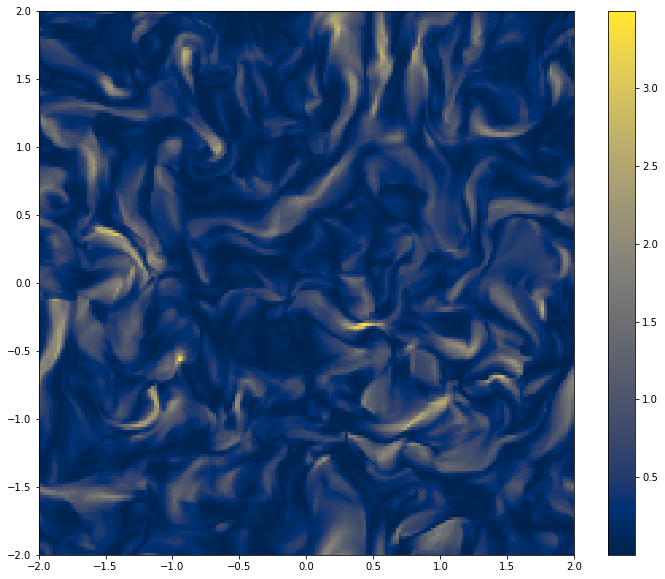

In [38]:
fig,ax=plt.subplots(figsize = (12,10))
Z1 = plt.pcolor(X, Y, kineticEnergy,cmap = 'cividis')
CB2 = plt.colorbar(Z1)
plt.show()

# TASK 2: 

Carry out the 2D Fast Fourier Transform of the kinetic energy image that you produced above, and make a map of it.

In [39]:
fourier_1 = np.fft.fft2(kineticEnergy)# this part calculates the fast fourier transform of the data.
shifted_fourier_1 = np.fft.fftshift(fourier_1)# shifting
norm_fourier_1 = np.abs(shifted_fourier_1)# As we have complex numbers, we calculate the norm

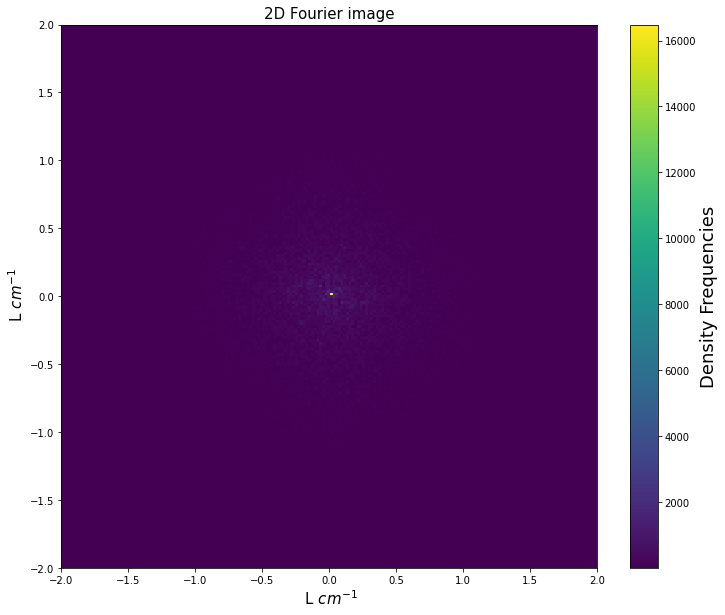

In [40]:
fig,ax=plt.subplots(figsize = (12,10))
Z2 = plt.pcolor(X, Y, norm_fourier_1,cmap = 'viridis')
CB2 = plt.colorbar(Z2)
CB2.set_label('Density Frequencies', size=18)
ax.set_xlabel( r' L $cm^{-1}$',fontsize='15')
ax.set_ylabel(r' L $cm^{-1}$',fontsize='15')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('2D Fourier image',fontsize='15')
plt.show()



# TASK 3: 

Use the function below to produce a 1D Fourier spectrum from the 2D Fourier image that you produced above. Make a log-log plot of the 1D Fourier spetrum. You should get a plot similar to the sketch shown here (in the "cascade of turbulence" section):

https://github.com/ciencialatitud0/EPIC_2/blob/main/Day1/Basics-2/2c_python_II_lecture.ipynb

### Note:
The GetPSD1D() function calculates the azimuthal summation and will allow you to test whether the spectrum of this turbulence snaphot follows Kolmogorov or not.


In [41]:
from scipy import ndimage

In [42]:
#===================================================================
# Get PSD 1D (total radial power spectrum)
#===================================================================
def GetPSD1D(psd2D):
    h  = psd2D.shape[0]
    w  = psd2D.shape[1]
    wc = w//2
    hc = h//2

    # create an array of integer radial distances from the center
    Y, X = np.ogrid[0:h, 0:w]
    r    = np.hypot(X - wc, Y - hc).astype(int)

    # SUM all psd2D pixels with label 'r' for 0<=r<=wc
    # NOTE: this will miss power contributions in 'corners' r>wc
    psd1D = ndimage.sum(psd2D, r, index=np.arange(0, wc))

    return psd1D
#===================================================================

# Taken from: https://medium.com/tangibit-studios/2d-spectrum-characterization-e288f255cc59

In [43]:
espectrum=GetPSD1D(norm_fourier_1)

In [44]:
print(espectrum.shape)

(100,)


In [45]:
freqs_x = np.fft.fftfreq(kineticEnergy.shape[0])

In [46]:
freqs=freqs_x[1:200//2]

In [47]:
freqs.shape

(99,)

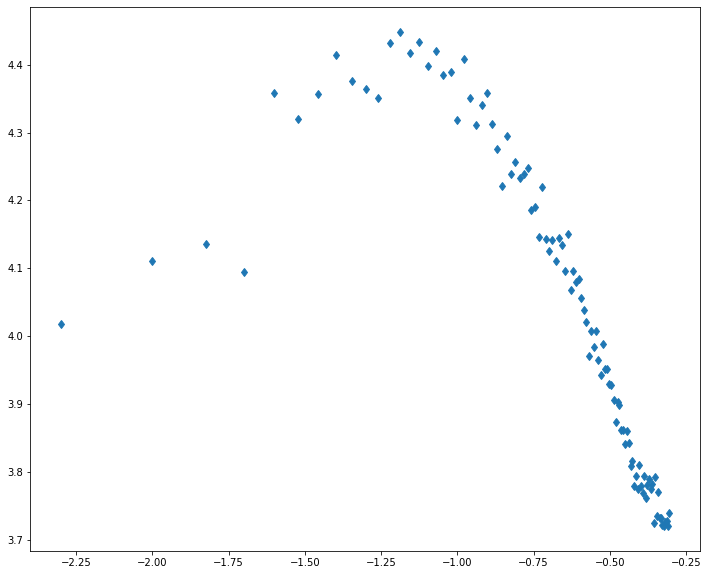

In [48]:
fig,ax=plt.subplots(figsize = (12,10))
ax.plot(np.log10(freqs),np.log10(espectrum[1::]),linestyle=' ',marker='d')
plt.show()

# TASK 4: 

Now that you have produced the 1D Fourier spectrum of the kinetic energy, label the plot identifying the turbulence generation, transfer, and dissipation regions. Finally, carry out a linear regression considering only the points associated with the inertial range. Does the spectrum follow Kolmogorov spectrum, $E_k \propto k^{-\frac{5}{3}}$?

### Reference:

https://github.com/ciencialatitud0/EPIC_2/blob/main/Day1/Basics-1/Sesion_1_Data_analysis_with_PythonI.ipynb

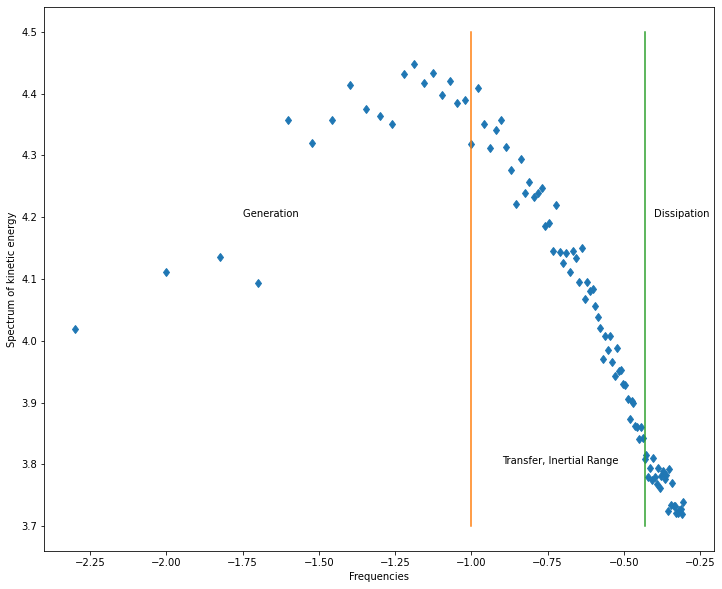

In [49]:
fig,ax=plt.subplots(figsize = (12,10))
ax.plot(np.log10(freqs),np.log10(espectrum[1::]),linestyle=' ',marker='d')
ax.plot(np.ones(10)*-1,np.linspace(3.7,4.5,10))
ax.plot(np.ones(10)*-0.43,np.linspace(3.7,4.5,10))
ax.annotate("Generation ",xy=(-1.75,4.2))
ax.annotate("Dissipation ",xy=(-0.4,4.2))
ax.annotate("Transfer, Inertial Range ",xy=(-0.9,3.8))
ax.set_xlabel("Frequencies")
ax.set_ylabel("Spectrum of kinetic energy")
plt.show()

In [75]:
g=np.log10(freqs)
h=np.log10(espectrum[1::])
d = np.where((g>-1) & (g<0.43), h, np.nan)
d = d[~np.isnan(d)]

[4.40900169 4.35076211 4.31137544 4.34100525 4.35782446 4.31338565
 4.27591905 4.22168058 4.29500938 4.23964625 4.25679536 4.23308135
 4.23943863 4.24769529 4.18621899 4.19058303 4.14572412 4.21907787
 4.14339605 4.12578727 4.14193889 4.11134489 4.14486758 4.13366426
 4.09539562 4.150222   4.06806748 4.09540378 4.07984569 4.08421837
 4.05674934 4.03780184 4.0214305  3.97051442 4.00822104 3.98455509
 4.00819296 3.96544616 3.94329082 3.98778649 3.95182893 3.95198372
 3.92967507 3.92805171 3.90522113 3.87319024 3.90247134 3.89877345
 3.86141791 3.86095789 3.84159846 3.8603256  3.84257497 3.80868845
 3.81559849 3.77879375 3.79437669 3.77515648 3.81024145 3.77868609
 3.76825574 3.79350291 3.76130777 3.78063231 3.78919582 3.7754269
 3.78225368 3.72433605 3.79240236 3.73447284 3.76971514 3.73189418
 3.73256366 3.72169928 3.72081151 3.72650794 3.72758104 3.72004701
 3.73953583]


In [77]:
e=np.where((g>-1) & (g<0.43),g,np.nan)
e = e[~np.isnan(e)]

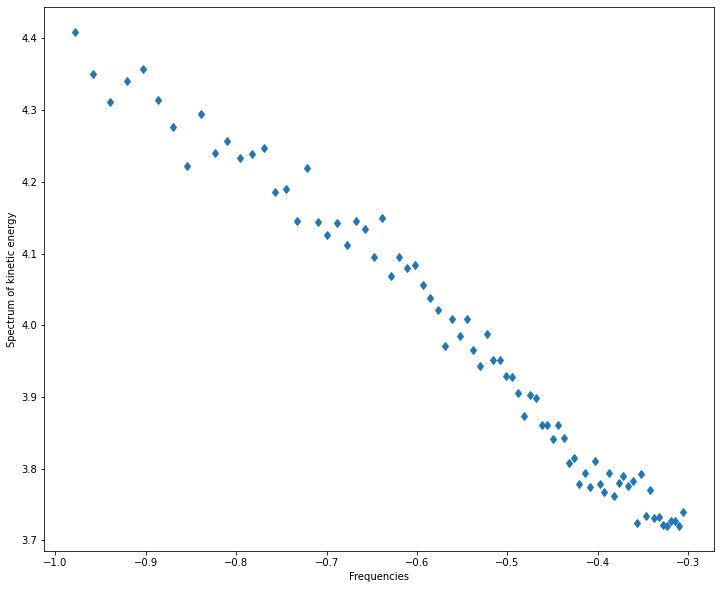

In [95]:
fig,ax=plt.subplots(figsize = (12,10))
ax.plot(e,d,linestyle=' ',marker='d')
ax.set_xlabel("Frequencies")
ax.set_ylabel("Spectrum of kinetic energy")
plt.show()

In [79]:
# Get coefficients

a, b = np.polyfit(e, d, 1)

# Print to check
print('slope =', a, ' intercept=', b)

# Get fitting function
fit_thickness = a*e + b

slope = -1.0634438194238631  intercept= 3.388007223257672


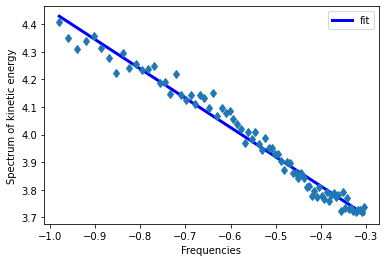

In [99]:
# Now we plot the data and the fit
fig, ax = plt.subplots()

#ax.plot(,thickness,color='red', marker = "d", linestyle=" ", linewidth=3, label="thickness vs. pages") 
ax.plot(e,fit_thickness,color='blue', linestyle="-", linewidth=3, label="fit") 
ax.plot(e,d,linestyle=' ',marker='d')
ax.set_xlabel("Frequencies")
ax.set_ylabel("Spectrum of kinetic energy")
ax.legend()
plt.show()

In [112]:
def kolmo(ar):
    E=np.sign(ar) * (np.abs(ar))**(-5/3)
    return E

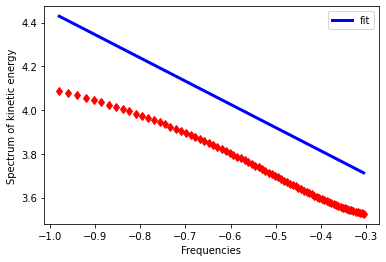

In [124]:
# Now we plot the data and the fit
fig, ax = plt.subplots()
ax.plot(e,(5/3)**kolmo(e)+3.5,color='red', marker = "d", linestyle=" ", linewidth=3) 
ax.plot(e,fit_thickness,color='blue', linestyle="-", linewidth=3, label="fit") 
ax.set_xlabel("Frequencies")
ax.set_ylabel("Spectrum of kinetic energy")
ax.legend()
plt.show()

In [60]:
## So, it follows the kolmogorov model beacause they cleary have similar slope